In [1]:
%matplotlib inline
import GEOparse
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import explained_variance_score, plot_roc_curve
import statsmodels.api as sm
from scipy.stats import ttest_ind
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklego.linear_model import LowessRegression
import os
import re

### Reading in from external source

In [2]:
data = pd.read_csv("../Dataset/Kryczka2021/data.csv")
data

,type,hsa-let-7i,hsa-miR-1228,hsa-miR-23a,hsa-miR-361
0,cancer,0.1622,6.2868,0.0957,0.1591
1,cancer,0.3414,6.0746,0.1842,0.1646
2,cancer,0.2141,4.4213,0.1575,0.2262
3,cancer,0.1276,17.7062,0.0244,0.0565
4,cancer,0.8263,3.7514,0.2196,0.2666
5,cancer,0.0661,20.2151,0.0010,0.0495
6,cancer,0.4725,6.5096,0.0895,0.1536
7,cancer,0.1455,8.0890,0.0659,0.1236
8,cancer,0.1815,7.4410,0.0898,0.1344
9,cancer,0.0743,7.7622,0.0323,0.1288


In [3]:
table = data.iloc[:, 1:]
mirnas = data.columns[1:]

### Seperate case and controls

In [4]:
controls = data["type"] == "control"
sick = 1 - controls

In [5]:
sum(controls)

21

### Drop NAN

In [6]:
table = table.dropna(1)

C:\Users\olefr\AppData\Local\Temp/ipykernel_11360/1927661217.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  table = table.dropna(1)


### T-test

In [7]:
X = table

In [8]:
X_healthy, X_cancer = X[controls == 1], X[sick == 1]

In [9]:
results = ttest_ind(X_healthy, X_cancer).pvalue

In [10]:
lowest, pvalues = np.argsort(results)[:5], np.sort(results)[:5]

In [11]:
mirnas[lowest], pvalues

(Index(['hsa-miR-23a', 'hsa-let-7i', 'hsa-miR-1228', 'hsa-miR-361'], dtype='object'),
 array([0.0049308 , 0.0138448 , 0.29366133, 0.71582993]))

### F-test

In [12]:
t3 = table

In [13]:
f, p = f_classif(t3, sick)

In [14]:
np.mean(p)

0.257066714406117

### ANOVA

In [15]:
t3

,hsa-let-7i,hsa-miR-1228,hsa-miR-23a,hsa-miR-361
0,0.1622,6.2868,0.0957,0.1591
1,0.3414,6.0746,0.1842,0.1646
2,0.2141,4.4213,0.1575,0.2262
3,0.1276,17.7062,0.0244,0.0565
4,0.8263,3.7514,0.2196,0.2666
5,0.0661,20.2151,0.0010,0.0495
6,0.4725,6.5096,0.0895,0.1536
7,0.1455,8.0890,0.0659,0.1236
8,0.1815,7.4410,0.0898,0.1344
9,0.0743,7.7622,0.0323,0.1288


In [16]:
X = np.array(sick).reshape(-1, 1)

In [17]:
linreg = LinearRegression()
linreg.fit(X, t3)

LinearRegression()

In [18]:
fitted = linreg.predict(X)
explained_variance_score(t3, fitted, multioutput="variance_weighted")

0.022300311387345086

### Mean-variance-plot

In [19]:
np.mean(table)

hsa-let-7i      0.264171
hsa-miR-1228    7.135790
hsa-miR-23a     0.075700
hsa-miR-361     0.198858
dtype: float64

In [20]:
def get_means_and_variances(table):
    return np.mean(table), np.var(table, ddof=1)

In [21]:
def mean_variance_plot(table):
    means, variances = get_means_and_variances(table)
    plt.scatter(means, variances)
    plt.xlabel("mean")
    plt.ylabel("variance")
    plt.plot()

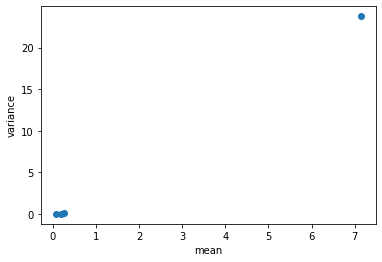

In [22]:
mean_variance_plot(table)

### Log transformation

In [23]:
log_table = np.log2(table)

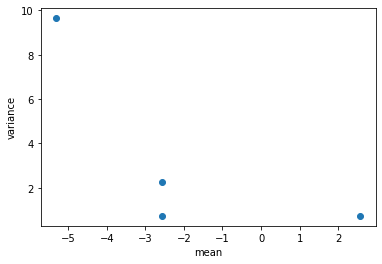

In [24]:
mean_variance_plot(log_table)

In [25]:
norm_log_table = log_table - np.mean(log_table)

In [26]:
norm_log_table /= np.sqrt(np.mean(np.var(norm_log_table, ddof=1)))

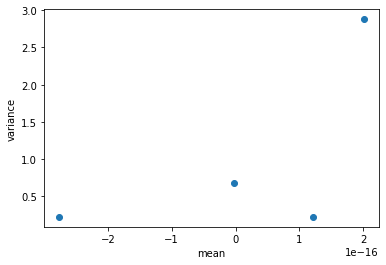

In [27]:
mean_variance_plot(norm_log_table)

### PCA

In [28]:
pca = decomposition.PCA(n_components=2)

In [29]:
pca.fit(norm_log_table)

PCA(n_components=2)

In [30]:
pca.explained_variance_ratio_

array([0.83363628, 0.10486475])

In [31]:
components = pca.transform(norm_log_table)

In [32]:
components.shape

(52, 2)

In [33]:
sum(controls)

21

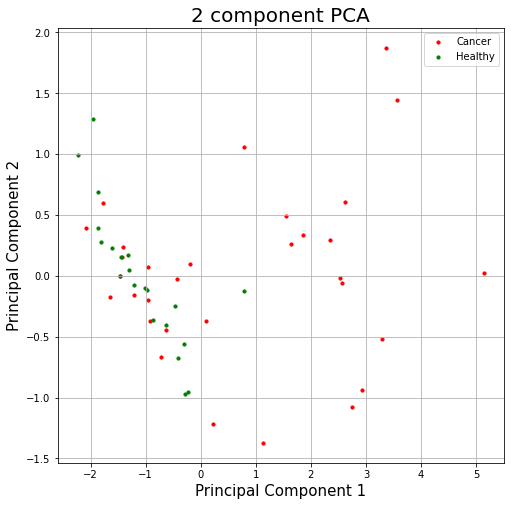

In [34]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components[controls == False, 0], components[controls == False, 1], c = 'r', s = 10)
ax.scatter(components[controls == True, 0], components[controls == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

In [35]:
components2 = components[components[:,0] < 20, :]
controls2 = controls[components[:,0] < 20]

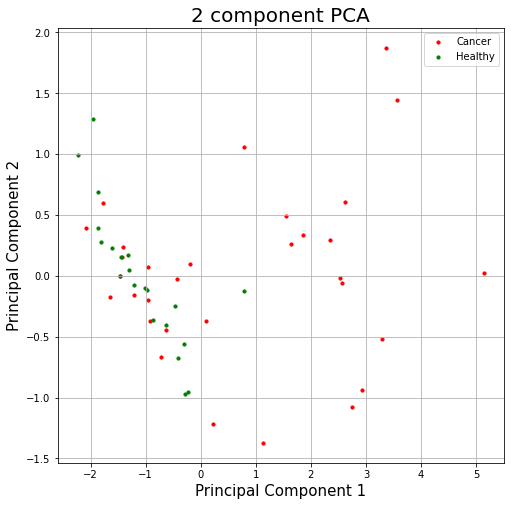

In [36]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components2[controls2 == False, 0], components2[controls2 == False, 1], c = 'r', s = 10)
ax.scatter(components2[controls2 == True, 0], components2[controls2 == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

### Logistic Regression

In [37]:
X_train, X_test, y_train, y_test = train_test_split(norm_log_table, controls, test_size=0.33, random_state=42)

In [38]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

C:\Users\olefr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


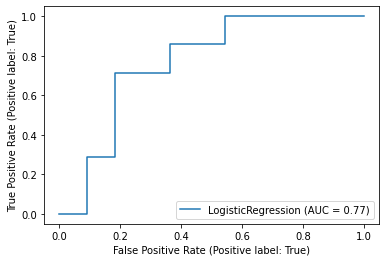

In [39]:
plot_roc_curve(model, X_test, y_test)

### XGBoost

In [40]:
model = XGBClassifier(use_label_encoder=False)
model.fit(X_train, y_train)

[08:06:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

C:\Users\olefr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


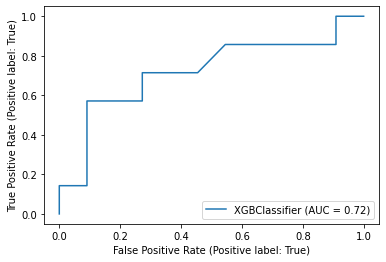

In [41]:
plot_roc_curve(model, X_test, y_test)

### Export data

In [42]:
from Scripts import converters

In [43]:
sequences = converters.canonical_to_seq(mirnas)

In [44]:
norm_log_table *= -1
norm_log_table.columns = sequences
norm_log_table["cancer"] = sick
norm_log_table.head()

,CUGGCUGAGGUAGUAGUUUGUGCUGUUGGUCGGGUUGUGACAUUGCCCGCUGUGGAGAUAACUGCGCAAGCUACUGCCUUGCUA,UCACACCUGCCUCGCCCCCC,AUCACAUUGCCAGGGAUUUCC,UUAUCAGAAUCUCCAGGGGUAC,cancer
0,0.035805,-0.041609,-1.053663,0.041421,1
1,-0.550751,-0.014547,-1.569742,0.014636,1
2,-0.182994,0.235832,-1.446322,-0.235916,1
3,0.224904,-0.857702,0.023442,0.857380,1
4,-1.247394,0.365328,-1.708287,-0.365431,1


In [45]:
norm_log_table.to_csv("../TransformedData/Kryczka2021.csv", index=False)